# Load data

In [17]:
import pandas as pd
final_df = pd.read_csv("/content/drive/MyDrive/Y2425S1/DSA4266/final_df.csv",on_bad_lines="warn", lineterminator="\n")

# Step 1: Load the trained CNN model
model = load_model('/content/drive/MyDrive/Y2425S1/DSA4266/Submissoin/best_cnn_model.keras')

# Step 2: Prepare the data
X = final_df.drop(final_df.columns[6], axis=1)  # Features (dropping label column)
y = final_df.iloc[:, 6]  # Labels (the target column)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
testor = pd.read_csv("/content/drive/MyDrive/Y2425S1/DSA4266/Nigerian_5.csv",on_bad_lines="warn", lineterminator="\n")

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Make sure to download stopwords and WordNet data if you haven’t done so
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# Preprocessing for Deep Learning Models
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r'(http|https)://(?:www\.)?\S+|www\.\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'\W+', ' ', text)
    # Tokenization
    tokens = text.split()
    # Lemmatization and stopword removal
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Preprocess subject and body columns
def preprocess_df(df):
    df['subject_clean'] = df['subject'].apply(preprocess_text)
    df['body_clean'] = df['body'].apply(preprocess_text)
    df['combined_clean'] = df['subject_clean'] + ' ' + df['body_clean']
    return df

combined_df = preprocess_df(testor)

# CNN Embedding Model

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Embeddings shape: (6331, 1, 64)


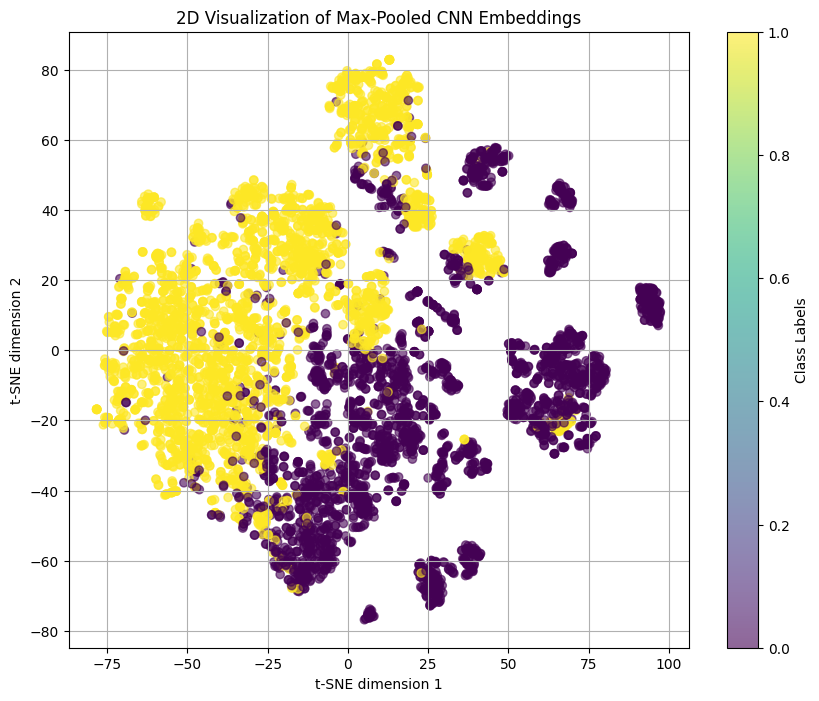

In [25]:
# maxpool to reshape + TSNE
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the trained CNN model
cnn_model = load_model('/content/drive/MyDrive/Y2425S1/DSA4266/Submissoin/best_cnn_model.keras')

# Set parameters
max_words = 1750  # Limit the number of words
max_len = 750  # Maximum number of words per email

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train['combined_clean'])
# Convert texts to sequences and pad them
testor_seq = tokenizer.texts_to_sequences(combined_df['combined_clean'])
testor_padded = pad_sequences(testor_seq, maxlen=max_len)

# Create an input layer matching the model's input shape
input_shape = (max_len,)  # Assuming max_len is 750
inputs = Input(shape=input_shape)

# Get the output from the embedding layer
embedding_layer_index = 0  # The embedding layer is the first layer
embedding_layer_output = cnn_model.layers[embedding_layer_index](inputs)

# Apply Max Pooling across the time dimension
# Assume the embedding output shape is (num_samples, max_len, embedding_dim)
max_pooling_layer = MaxPooling1D(pool_size=max_len)(embedding_layer_output)

# Create a new model that outputs the max-pooled embeddings
embedding_model = Model(inputs=inputs, outputs=max_pooling_layer)

# Test the embedding model
embeddings_subset = embedding_model.predict(testor_padded)
print("Embeddings shape:", embeddings_subset.shape)

# Reshape the embeddings for visualization
# The output shape after Max Pooling will be (num_samples, embedding_dim)
embeddings_reshaped = embeddings_subset.reshape(embeddings_subset.shape[0], -1)

# Continue with PCA and t-SNE as before...
pca = PCA(n_components=50)  # Reduce to 50 dimensions
embeddings_pca = pca.fit_transform(embeddings_reshaped)

# Further reduce to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Assuming testor['label'] contains the labels for coloring the points
colors = combined_df['label']  # Make sure this is defined and corresponds to your samples

# Plotting the embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap='viridis', alpha=0.6)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("2D Visualization of Max-Pooled CNN Embeddings")
plt.colorbar(scatter, label='Class Labels')  # Add color bar for reference
plt.grid(True)
plt.show()


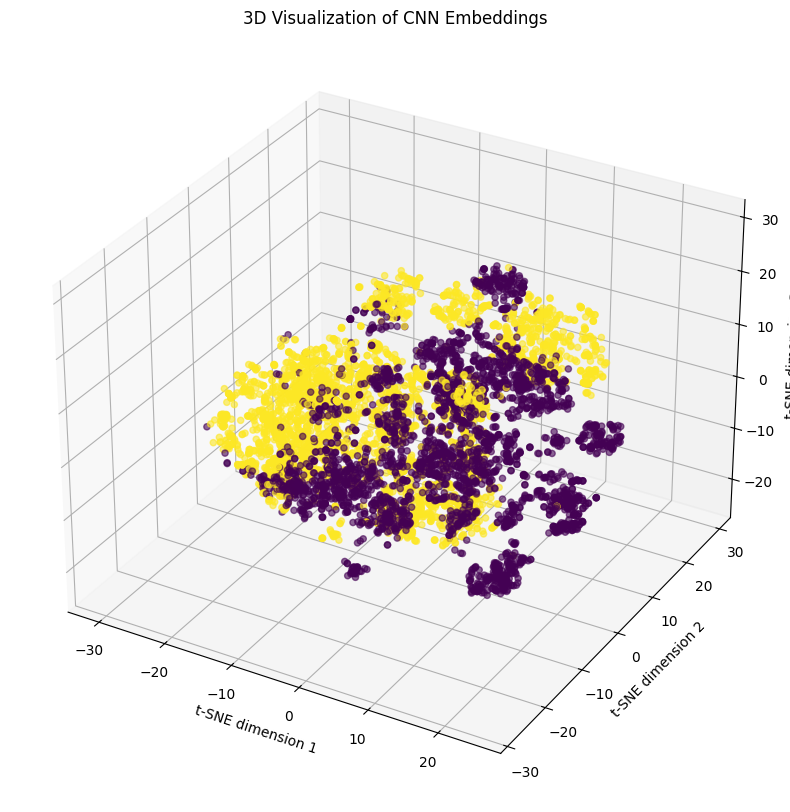

In [27]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming embeddings_2d is already obtained from t-SNE
# If you're reducing to 2D for visualization, you need to update it for 3D (using n_components=3 in t-SNE)

# t-SNE with 3 components (instead of 2)
tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings_pca)  # embeddings_pca was already reduced to 50D

# Plotting the embeddings in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=colors, cmap='viridis', alpha=0.6)

# Labels and title
ax.set_xlabel("t-SNE dimension 1")
ax.set_ylabel("t-SNE dimension 2")
ax.set_zlabel("t-SNE dimension 3")
ax.set_title("3D Visualization of CNN Embeddings")

# Show plot
plt.show()


# BERT Embedding Model

In [7]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import pipeline
import torch

In [8]:
from huggingface_hub import login
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Login to Hugging Face Hub (Ensure you have the token)
login(token="PLACEHOLDER_TOKEN")

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Embeddings shape: (6331, 1024)
Original embeddings shape: (6331, 1024)


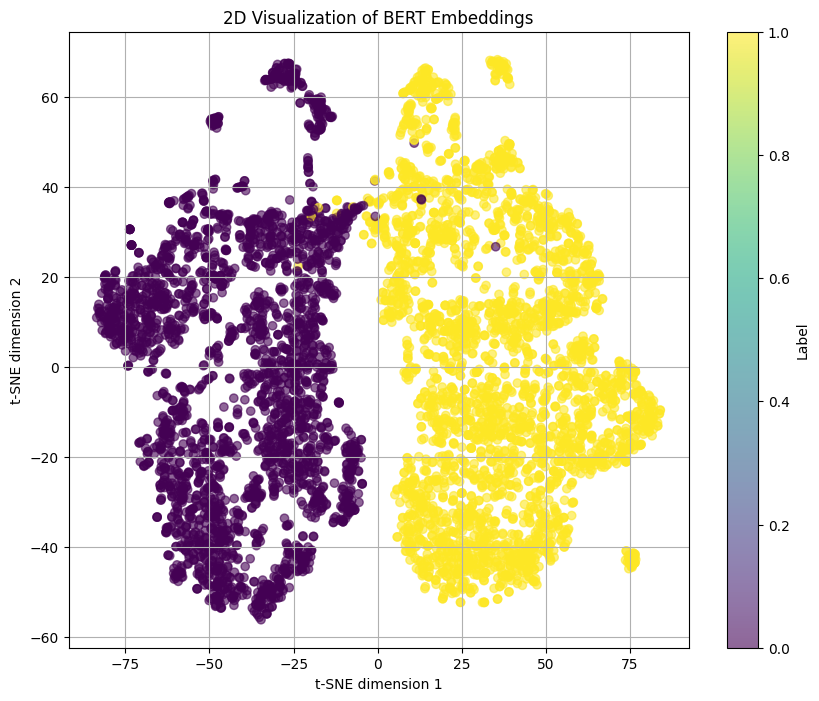

In [9]:
# Step 1: Load the fine-tuned BERT model
classifier = pipeline("text-classification", model="/content/drive/MyDrive/Y2425S1/DSA4266/Submissoin/models/BERT_Fine_Tuned", device = 0)

# Step 2: Prepare the data (assuming you have `final_df` already loaded with text and labels)
X = combined_df['combined_clean'].tolist()  # Features (text column)
y = combined_df['label']  # Labels (target column)

# Step 3: Extract embeddings using the BERT model
# Note: Modify the pipeline to output hidden states for embeddings extraction
from transformers import AutoModel, AutoTokenizer

# Load tokenizer and model for embedding extraction
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Y2425S1/DSA4266/Submissoin/models/BERT_Fine_Tuned")
model = AutoModel.from_pretrained("/content/drive/MyDrive/Y2425S1/DSA4266/Submissoin/models/BERT_Fine_Tuned")
model = model.to('cuda')

# Ensure X is a list of strings
X = combined_df['combined_clean'].tolist()

# Optimized embedding extraction function
def get_bert_embeddings_batch(text_list, model, tokenizer, batch_size=512, max_len=512):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch_text = text_list[i:i + batch_size]
        # Tokenize the batch of texts
        inputs = tokenizer(batch_text, max_length=max_len, padding=True, truncation=True, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model(**inputs)
            # Use the CLS token's hidden state as the embedding
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)

    return np.vstack(embeddings)

# Get embeddings for the text data
embeddings = get_bert_embeddings_batch(X, model, tokenizer)
print("Embeddings shape:", embeddings.shape)

# Step 4: Dimensionality Reduction with PCA and t-SNE
# Reshape the embeddings if necessary
print(f"Original embeddings shape: {embeddings.shape}")

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Step 5: Plotting the embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label="Label")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("2D Visualization of BERT Embeddings")
plt.grid(True)
plt.show()

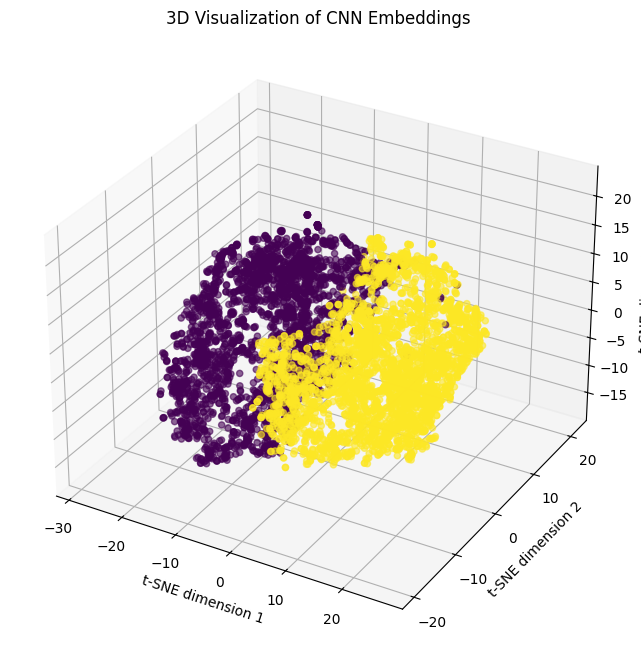

In [11]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming embeddings_2d is already obtained from t-SNE
# If you're reducing to 2D for visualization, you need to update it for 3D (using n_components=3 in t-SNE)

# t-SNE with 3 components (instead of 2)
tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings_pca)  # embeddings_pca was already reduced to 50D

# Plotting the embeddings in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=y, cmap='viridis', alpha=0.6)

# Labels and title
ax.set_xlabel("t-SNE dimension 1")
ax.set_ylabel("t-SNE dimension 2")
ax.set_zlabel("t-SNE dimension 3")
ax.set_title("3D Visualization of BERT Embeddings")

# Show plot
plt.show()
